In [1]:
import pickle
import pandas as pd
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error
from datetime import datetime
from pandas.plotting import lag_plot
import scipy.stats as st
from scipy.stats import chisquare
from statsmodels.tsa.stattools import adfuller
import math
from sklearn import linear_model

/Users/parth/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# f = open(os.getcwd() + '/data/scratch/sri223/segments/final/2014-08-01-segments-speeds-avged.pickle')
# obj = pd.read_pickle(os.getcwd()+ '/data/scratch/sri223/segments/final/2014-08-01-segments-speeds-avged.pickle')

In [6]:
# keys_with_data = []
# for k, v in obj.items():
# #     if(len(keys_with_data) < 5)
#     keys_with_data.append((k, v.isnull().sum().AvgSpeed))
    
# keys_with_data = sorted(keys_with_data, key=lambda data: data[1])

In [2]:
segment = ('500009','500010')
segment

('500009', '500010')

In [39]:
# for x in range(5):
#     directory = keys_with_data[x][0][0] + "-" + keys_with_data[x][0][1]
#     if not os.path.exists(directory):
#         os.makedirs(directory)
#     obj.get(keys_with_data[x][0]).to_pickle(directory + "/" + directory + ".pickle")

In [2]:
# path = os.getcwd() + '/data/scratch/sri223/segments/final/'
# i = 0
# for filename in glob.glob(os.path.join(path,'*.pickle')):
#     i = i+1
#     for x in range(5):
#         directory = segment[0] + "-" + segment[1]
#         if not os.path.exists(directory):
#             os.makedirs(directory)
#         f = open(filename)
#         obj = pd.read_pickle(filename)
#         obj.get(keys_with_data[x][0]).to_pickle(directory + "/" + directory + "-" + str(i) + ".pickle")
#         f.close()
               

In [3]:
directory = segment[0] + "-" + segment[1]

path = os.getcwd()  + "/" + directory
df = []
frames = []
for filename in glob.glob(os.path.join(path,'*.pickle')):
    f = open(filename)
    obj = pd.read_pickle(filename)
    frames.append(obj)
    f.close()

df = pd.concat(frames)
    

In [4]:
dates = []
for x in df.index:
    dates.append(datetime.fromtimestamp(x))
    
df.index = dates

In [5]:
df.count()

AvgSpeed    12253
dtype: int64

In [6]:
df= df.dropna()
# df = df.fillna(0)

In [7]:
# df = df.asfreq(freq='600S', fill_value=0.0)

In [8]:
df.isnull().sum()

AvgSpeed    0
dtype: int64

In [9]:
df = df.sort_index()

In [10]:
df.index.name = 'TimeStamp'

In [11]:
df.head()

,AvgSpeed
TimeStamp,
2014-08-01 04:00:00,5.453716
2014-08-01 04:10:00,5.535036
2014-08-01 04:20:00,6.758372
2014-08-01 04:30:00,9.907752
2014-08-01 04:40:00,7.605776


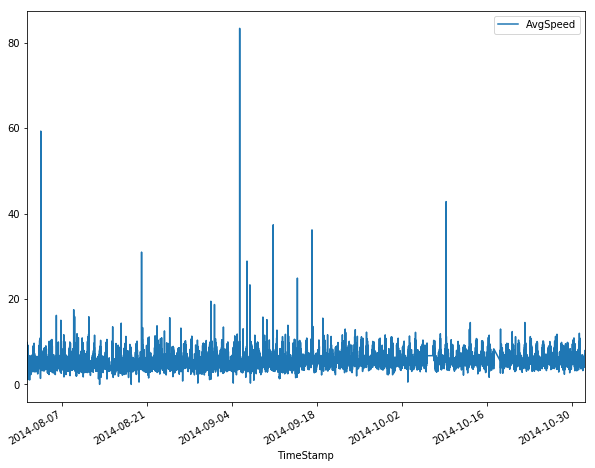

In [12]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
df.plot()
plt.show()

In [13]:
X_train = df[:'2014-10-16']
X_test = df['2014-10-16':]

In [15]:
# X_train.plot()


In [18]:
# autocorrelation_plot(X_train)

/Users/parth/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


In [14]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(center=False, window=12).mean()
    rolstd = timeseries.rolling(center=False, window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

In [15]:
print('Durbin Watson:',sm.stats.durbin_watson(X_train))
print('Augmented Dickey–Fuller test:',adfuller(X_train.iloc[:,0]))

Durbin Watson: [ 0.17908645]
Augmented Dickey–Fuller test: (-15.600277562070751, 1.8329267944265872e-28, 26, 10288, {'1%': -3.430985782694413, '5%': -2.8618209789974469, '10%': -2.5669195599763364}, 41721.138515295213)


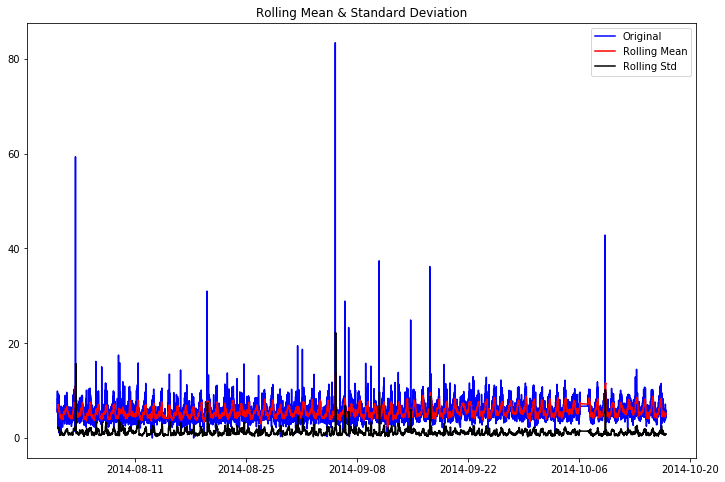

In [16]:
test_stationarity(X_train)

In [17]:
X = X_train.values
split = int(len(X) / 2)
print(split)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

# Results show that timeseries is stationary.

5157
mean1=5.275027, mean2=5.714686
variance1=4.744602, variance2=3.334836


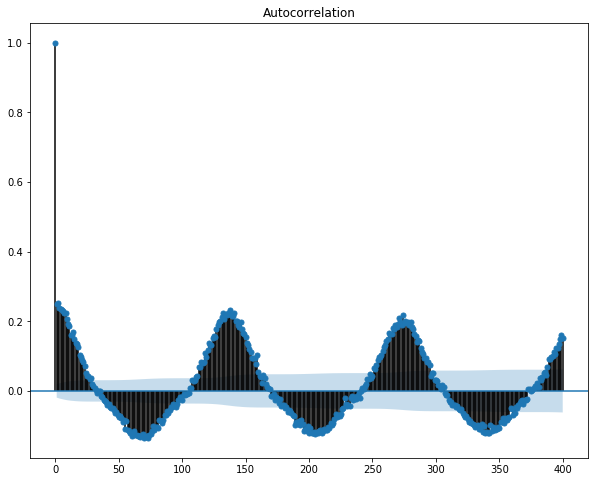

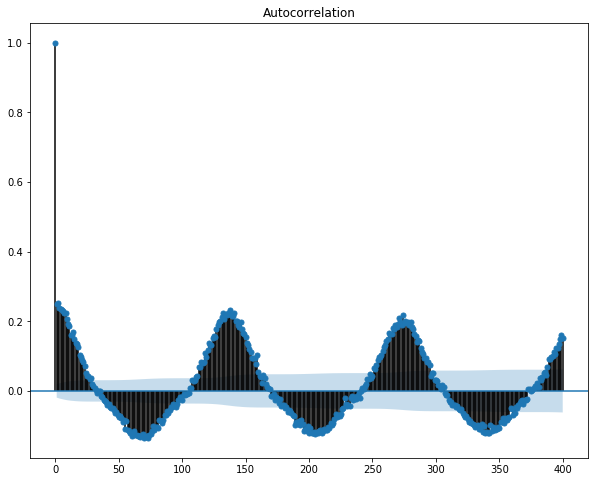

In [18]:
# This plot shows that there is a seasonal effect. 
# That means traffic in a given day at particular time depends on traffic exactly 24 hours ago on the same time.
plot_acf(X_train,ax=None, lags = 400)

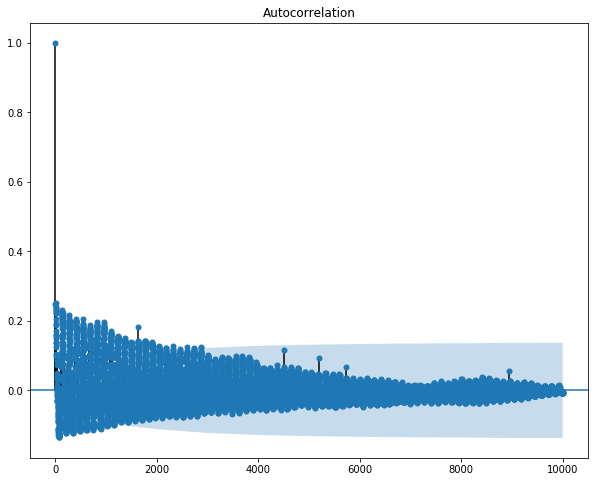

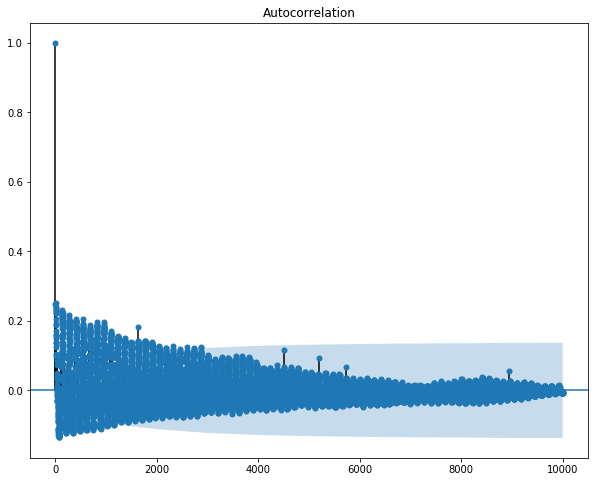

In [19]:
# Zoomed out version of ACF shows that it is slowly converging to zero which means timeseries is stationary
#  Also the first lag has significant impact compared to other lags that means MA term will be there. 
# But it will also have AR terms since after lag 1 acf is having geometric decay.
plot_acf(X_train,ax=None, lags = 10000)

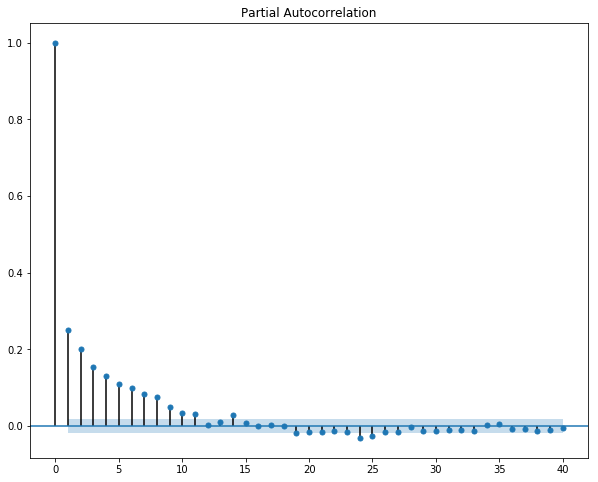

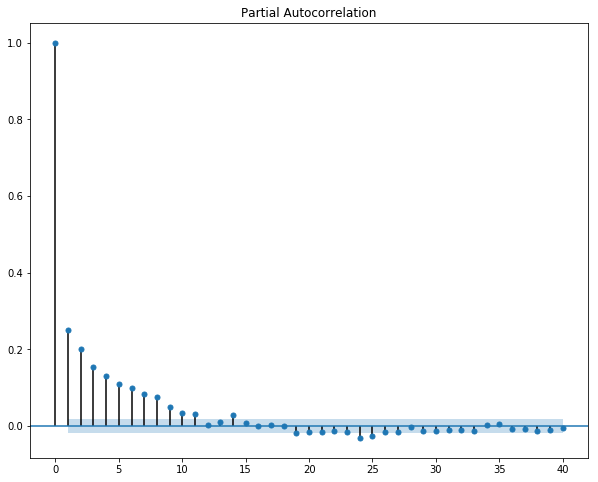

In [20]:
#  PACF shows that we can try to take past 6 lags 
plot_pacf(X_train,ax=None,lags = 40)

In [23]:
# fit model
# model = ARIMA(X_train, order=(2,0,1))
# model_fit = model.fit(disp=0)
# print(model_fit.summary())

In [24]:
# plot residual errors
# residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()
# pyplot.show()
# residuals.plot(kind='kde')
# pyplot.show()
# print(residuals.describe())

In [28]:
# train = X_train.iloc[:,0]
# test = X_test.iloc[:,0]

In [358]:
# train.head()

TimeStamp
2014-08-01 04:00:00     3.449183
2014-08-01 04:10:00     6.394708
2014-08-01 04:20:00     3.840358
2014-08-01 04:30:00    10.506753
2014-08-01 04:40:00     7.821193
Freq: 600S, Name: AvgSpeed, dtype: float64

In [368]:

# history = [x for x in train]
# predictions = list()
# for t in range(len(X_test)):
#     model = ARIMA(history, order=(2,0,1))
#     model_fit = model.fit(disp=0)
#     output = model_fit.forecast()
# #     print('output=' , output)
# #     print('output[0]=' , output[0])
#     yhat = output[0]
#     predictions.append(yhat)
#     obs = test[t]
# #     print('obs' , obs)
#     history.append(obs)
#     print('predicted=%f, expected=%f' % (yhat, obs))
# # error = mean_squared_error(test, predictions)
# # print('Test MSE: %.3f' % error)
# # plot
# pyplot.plot(X_test)
# pyplot.plot(predictions, color='red')
# pyplot.show()

predicted=5.181405, expected=3.520115
predicted=5.176270, expected=4.176801
predicted=5.075839, expected=4.403467
predicted=5.020684, expected=5.073352
predicted=4.999210, expected=4.624033
predicted=4.997342, expected=4.940465
predicted=4.984356, expected=4.832009
predicted=4.983726, expected=5.018134
predicted=4.983398, expected=5.543657
predicted=5.005559, expected=5.288968
predicted=5.041848, expected=4.209977
predicted=5.034041, expected=4.596931
predicted=4.989771, expected=6.069216
predicted=5.006891, expected=7.360664
predicted=5.122450, expected=3.919992
predicted=5.190232, expected=4.425878
predicted=5.112883, expected=5.292808
predicted=5.089133, expected=6.496622
predicted=5.138665, expected=4.854346
predicted=5.191968, expected=6.817797
predicted=5.220523, expected=6.011763
predicted=5.311228, expected=5.342157
predicted=5.339064, expected=5.595838
predicted=5.341400, expected=5.262447
predicted=5.345677, expected=7.583544
predicted=5.397699, expected=6.755974
predicted=5.

KeyboardInterrupt: 

In [331]:
# X_train = X_train.asfreq(freq='600s', fill_value=0.0)

In [21]:
# https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
mod = sm.tsa.statespace.SARIMAX(X_train,
                                order=(8, 0, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# results = mod.fit()

# print(results.summary().tables[1])

In [22]:
results = mod.fit(disp=0)

In [23]:
print(results.summary().tables[0])

                           Statespace Model Results                           
Dep. Variable:               AvgSpeed   No. Observations:                10315
Model:               SARIMAX(8, 0, 1)   Log Likelihood              -21024.183
Date:                Sat, 23 Dec 2017   AIC                          42068.365
Time:                        15:05:20   BIC                          42140.779
Sample:                    08-01-2014   HQIC                         42092.839
                         - 10-16-2014                                         
Covariance Type:                  opg                                         


In [24]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9436      0.017     56.683      0.000       0.911       0.976
ar.L2          0.0180      0.006      2.791      0.005       0.005       0.031
ar.L3         -0.0006      0.007     -0.091      0.927      -0.014       0.013
ar.L4          0.0105      0.008      1.360      0.174      -0.005       0.026
ar.L5          0.0072      0.007      1.022      0.307      -0.007       0.021
ar.L6          0.0130      0.006      2.042      0.041       0.001       0.025
ar.L7          0.0048      0.009      0.537      0.591      -0.013       0.022
ar.L8          0.0020      0.008      0.250      0.803      -0.014       0.018
ma.L1         -0.8235      0.016    -50.336      0.000      -0.856      -0.791
sigma2         3.4608      0.005    749.493      0.000       3.452       3.470


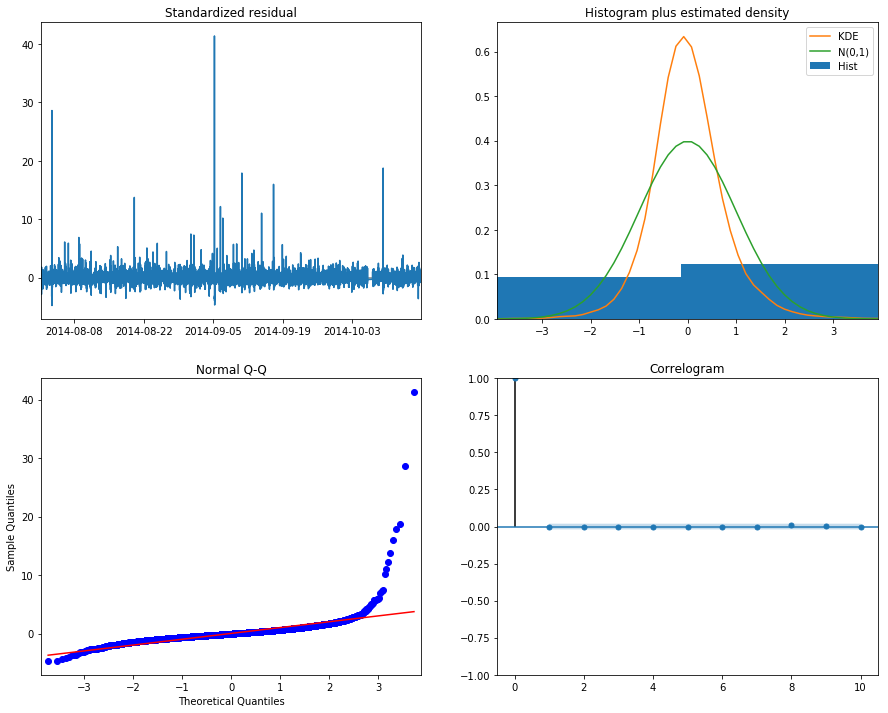

In [25]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
# Our primary concern is to ensure that the residuals of our model are uncorrelated and normally 
# distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, 
# it is a good indication that it can be further improved.

# In this case, our model diagnostics suggests that the model residuals are normally distributed 
# based on the following:

# 1. In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is 
# the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good 
# indication that the residuals are normally distributed.

# 2. The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear 
# trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication 
# that the residuals are normally distributed.

# 3. The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise.
# This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time 
# series residuals have low correlation with lagged versions of itself.

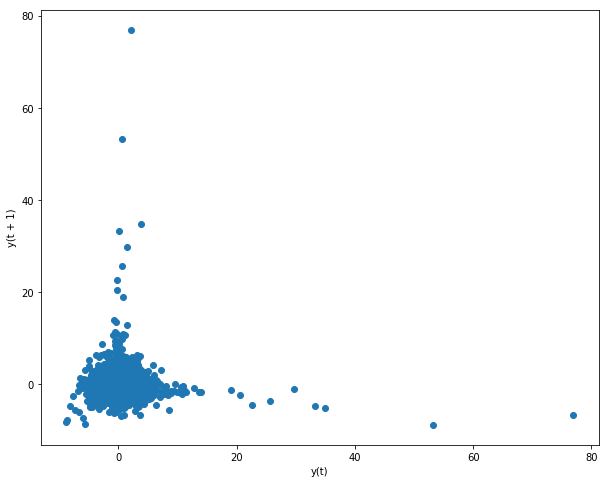

In [26]:
# Lag plot shows that there is not such pattern in the lags but it has outliers.
lag_plot(results.resid)
plt.show()

In [27]:
# The dynamic=False argument ensures that we produce one-step ahead forecasts,
# meaning that forecasts at each point are generated using the full history up to that point.
pred = results.get_prediction(start=pd.to_datetime('2014-09-20'), dynamic=False)
pred_ci = pred.conf_int()

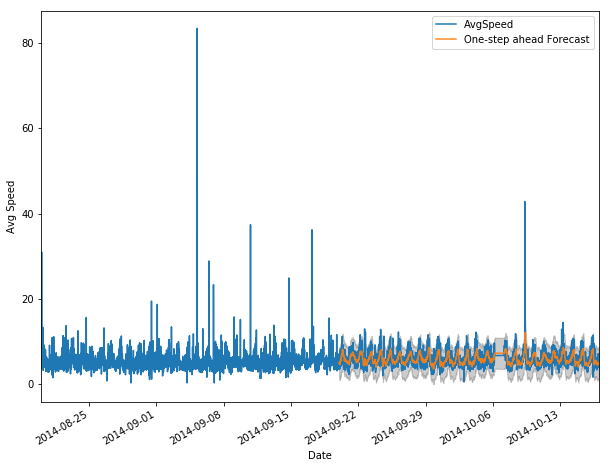

In [28]:
# In-sample prediction  . How our insample prediction looks compared to actual data.
ax = X_train['2014-08-20':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Avg Speed')
plt.legend()

plt.show()

In [29]:
X_train_forecasted = pred.predicted_mean
X_train_truth = X_train['2014-09-20':]

# Compute the mean square error
mse = ((X_train_forecasted - X_train_truth.iloc[:,0]) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2.01


In [31]:
# X_test.count()

In [42]:
# Finally we will forcast the future value and compare it with the test data


# pred_test = results.get_forecast(steps=2184)


# # Get confidence intervals of forecasts
# pred_ci = pred_test.conf_int()

In [44]:
# ax = X_test.plot(label='observed', figsize=(20, 15))
# pred_test.predicted_mean.plot(ax=ax, label='Forecast')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
# ax.set_xlabel('Date')
# ax.set_ylabel('Avg Speed')

# plt.legend()
# plt.show()

In [30]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(8, 0, 1),
                                
                                enforce_stationarity=True,
                                enforce_invertibility=False)

results = mod.fit(disp=0)

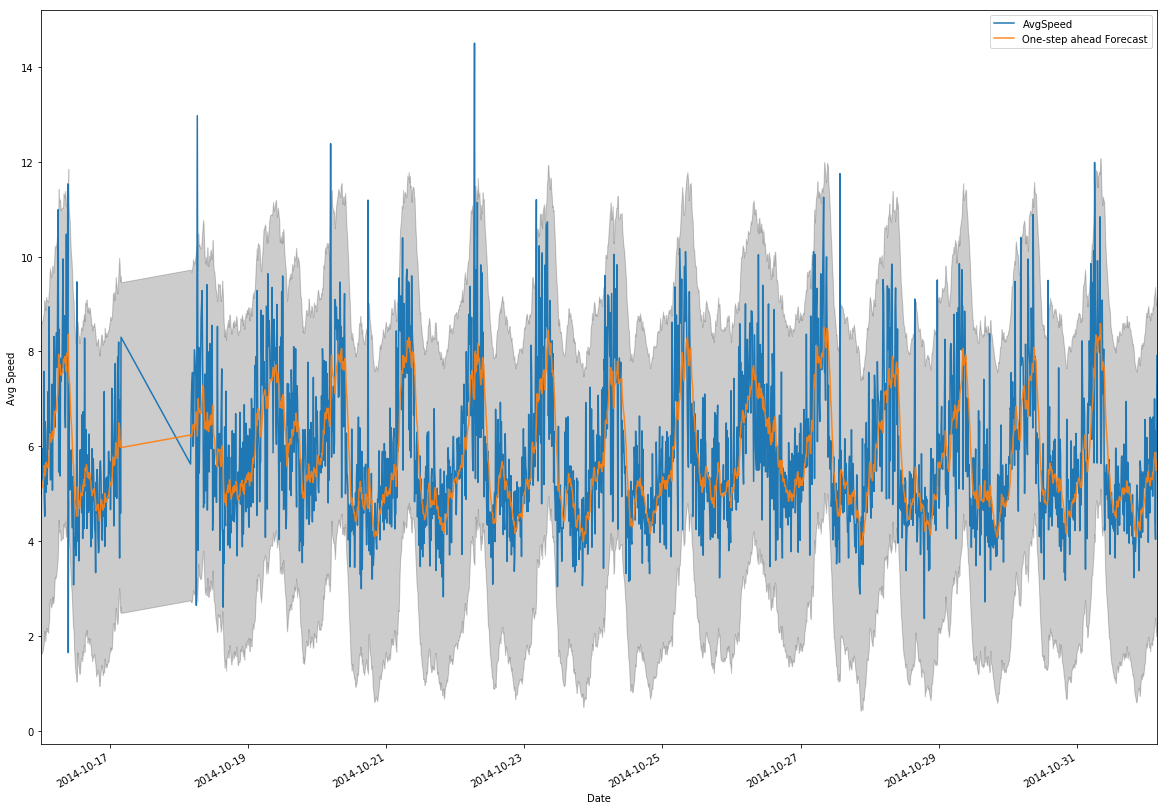

In [31]:
# Test data prediction.
pred = results.get_prediction(start=pd.to_datetime('2014-10-16'), dynamic=False)
pred_ci = pred.conf_int()

ax = df['2014-10-16':].plot(label='observed', figsize=(20, 15))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Avg Speed')
plt.legend()

plt.show()

In [32]:
X_test_forecasted = pred.predicted_mean
X_test_truth = X_test['2014-10-16':]

# Compute the mean square error
mse = ((X_test_forecasted - X_test_truth.iloc[:,0]) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.59


In [36]:
# chisquare(f_obs=X_test_forecasted, f_exp=X_test.iloc[:,0])

In [33]:
X_test_observed = [int(round(x)) for x in X_test_forecasted]
X_test_expected = [int(round(x)) for x in X_test.iloc[:,0]]

In [34]:
obs_frequencies = []
exp_freqiencies = []
for x in range(max(X_test_observed) +1):
    count = len([y for y in X_test_observed if y==x ]) 
    obs_frequencies.append(count)
    
    exp_count = len([y for y in X_test_expected if y==x ]) 
    
    exp_freqiencies.append(max(exp_count,1))

In [35]:
obs_frequencies

[0, 0, 0, 0, 166, 974, 421, 315, 198, 2]

In [36]:
exp_freqiencies

[1, 1, 2, 47, 368, 664, 472, 211, 161, 95]

In [37]:
obs = [x/sum(obs_frequencies) * 100 for x in obs_frequencies ]
exp = [x/sum(exp_freqiencies) * 100 for x in exp_freqiencies ]

In [38]:
chisquare(f_obs=obs, f_exp=exp)

Power_divergenceResult(statistic=21.651241364943907, pvalue=0.010052504808664351)

In [39]:
# From here  linear regression starts
df_arr = df.iloc[:,0]
df_arr.head()

TimeStamp
2014-08-01 04:00:00    5.453716
2014-08-01 04:10:00    5.535036
2014-08-01 04:20:00    6.758372
2014-08-01 04:30:00    9.907752
2014-08-01 04:40:00    7.605776
Name: AvgSpeed, dtype: float64

In [40]:
lag_1 = []
lag_2 = []
lag_3 = []
lag_4 = []
lag_5 = []
lag_144 = []
diff_1_2 = []
for x in range(len(df_arr)):

#   Lag_1
    if x-1 >= 0:
        lag_1.append(df_arr[x-1])
    else:
        lag_1.append(0)

#   Lag_2
    if x-2 >= 0:
        lag_2.append(df_arr[x-2])
    else:
        lag_2.append(0)

#   Lag_3
    if x-3 >= 0:
        lag_3.append(df_arr[x-3])
    else:
        lag_3.append(0)

#   Lag_4
    if x-4 >= 0:
        lag_4.append(df_arr[x-4])
    else:
        lag_4.append(0)
        
#   Lag_5
    if x-5 >= 0:
        lag_5.append(df_arr[x-5])
    else:
        lag_5.append(0)
        
#   Lag_144
    if x-144 >= 0:
        lag_144.append(df_arr[x-144])
    else:
        lag_144.append(0)
        
    diff_1_2.append(lag_1[x] - lag_2[x])


    

df['lag_1'] = pd.Series(lag_1, index=df.index)
df['lag_2'] = pd.Series(lag_2, index=df.index)
df['lag_3'] = pd.Series(lag_3, index=df.index)
df['lag_4'] = pd.Series(lag_4, index=df.index)
df['lag_5'] = pd.Series(lag_5, index=df.index)
df['lag_144'] = pd.Series(lag_144, index=df.index)
df['diff_1_2'] = pd.Series(diff_1_2, index=df.index)

In [41]:
train_df = df[:'2014-10-16']
test_df = df['2014-10-16':]

In [42]:
x_train = train_df[['lag_1','lag_2','lag_3','lag_4', 'lag_5','lag_144','diff_1_2']]
x_test = test_df[['lag_1','lag_2','lag_3','lag_4', 'lag_5','lag_144','diff_1_2']]
y_train = train_df[['AvgSpeed']]
y_test = test_df[['AvgSpeed']]

In [43]:
# Ridge regression
reg = linear_model.Ridge (alpha = 10)
reg.fit (x_train, y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [44]:
reg.coef_

array([[  1.27515565e-01,   1.27578565e-01,   1.07949885e-01,
          1.05535523e-01,   1.00976993e-01,   6.42097938e-02,
         -6.30004438e-05]])

In [45]:
predicted = reg.predict(x_test)

In [46]:
result = pd.DataFrame(predicted,index=x_test.index,columns=['predicted'])
result['expected'] = y_test['AvgSpeed']
result['residuals'] = result['expected'] - result['predicted']

In [47]:
result.head()

,predicted,expected,residuals
TimeStamp,,,
2014-10-16 00:00:00,5.497774,5.006387,-0.491387
2014-10-16 00:10:00,5.428829,5.239712,-0.189117
2014-10-16 00:20:00,5.391141,5.286980,-0.104162
2014-10-16 00:30:00,5.510852,5.339210,-0.171642
2014-10-16 00:40:00,5.419067,5.950522,0.531454


In [48]:
# R2 score
reg.score(x_test, y_test)

0.35052958036790449

In [49]:
residual_df = result[['residuals']]

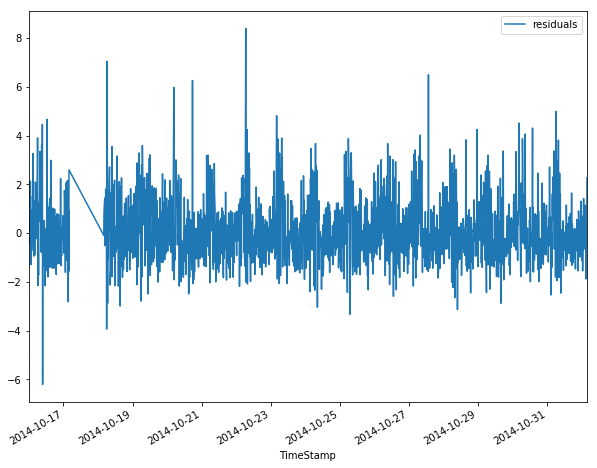

In [50]:
# Run Sequence plot
residual_df.plot()
plt.show()

# This shows that it's random and there are no patterns as such

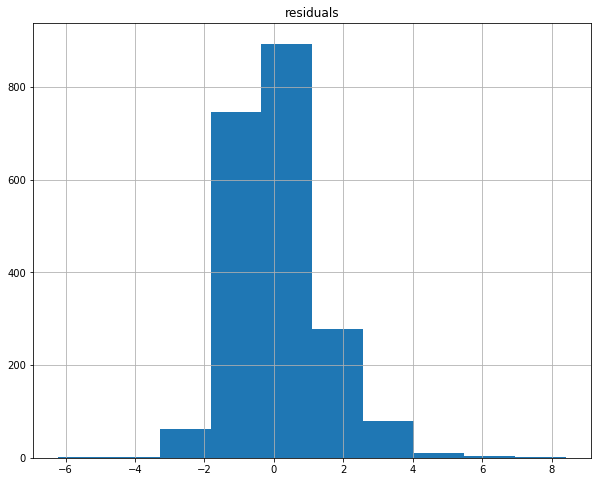

In [51]:
residual_df.hist()
plt.show()

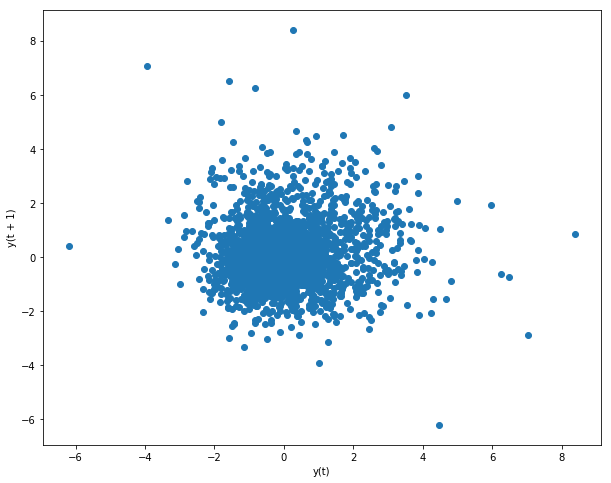

In [52]:
lag_plot(residual_df)
plt.show()

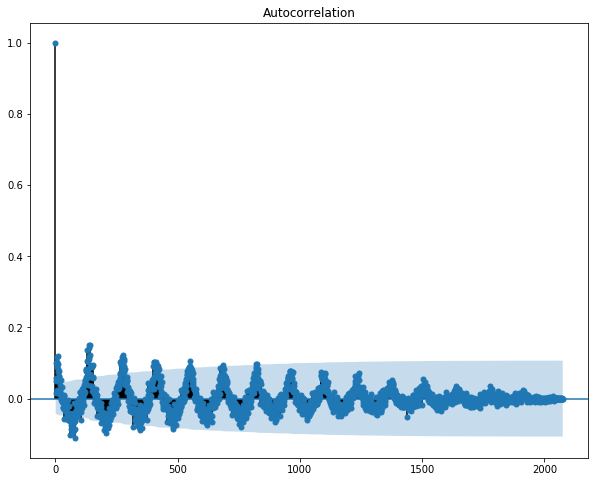

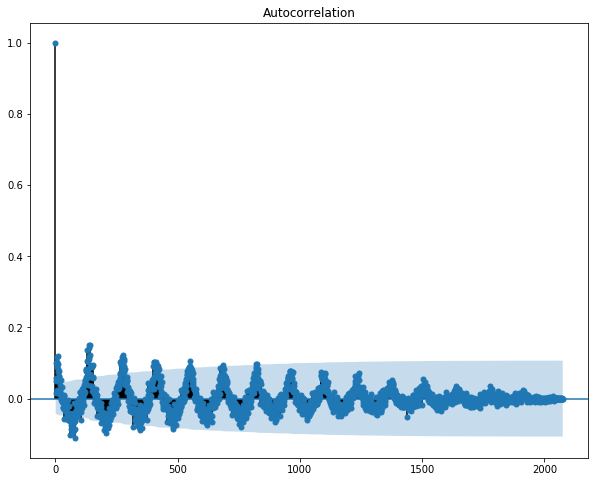

In [54]:
plot_acf(residual_df)
# This shows that we could i

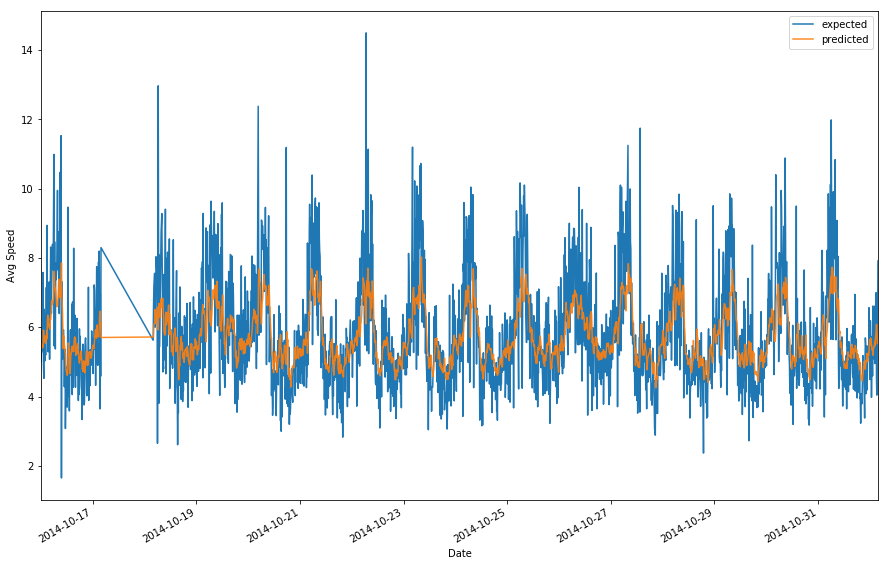

In [55]:
ax = result[['expected']].plot(label='observed', figsize=(15, 10))
result[['predicted']].plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

ax.set_xlabel('Date')
ax.set_ylabel('Avg Speed')
plt.legend()

plt.show()